In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv




df_path = os.listdir()[1]
df_og = pd.read_csv(df_path)
df = df_og.copy()


df['card'] = np.where(df.card =="yes", 1, 0)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = \
        train_test_split(df_full_train, test_size=0.25, random_state=1)



df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values


del df_train['card']
del df_val['card']
del df_test['card']

col_names = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
num_col = df_train.select_dtypes(include=np.number).columns.to_list()

--2022-09-29 13:01:05--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-09-29 13:01:05 (5.65 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



# Q1

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for c in num_col:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


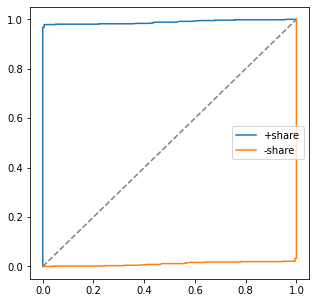

In [3]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.share)
plt.plot(fpr, tpr, label='+share')

fpr, tpr, _ = roc_curve(y_train, -df_train.share)
plt.plot(fpr, tpr, label='-share')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

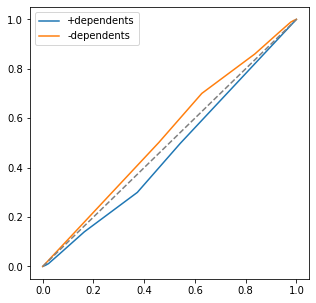

In [4]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.dependents)
plt.plot(fpr, tpr, label='+dependents')

fpr, tpr, _ = roc_curve(y_train, -df_train.dependents)
plt.plot(fpr, tpr, label='-dependents')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

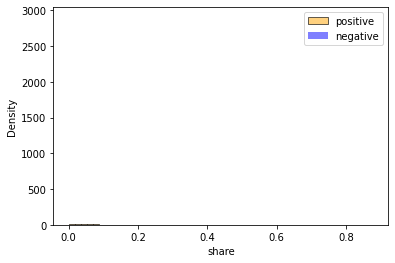

In [5]:
sns.histplot(df_train.share[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.share[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

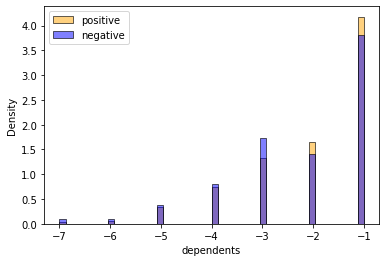

In [6]:
sns.histplot(~df_train.dependents[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(~df_train.dependents[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

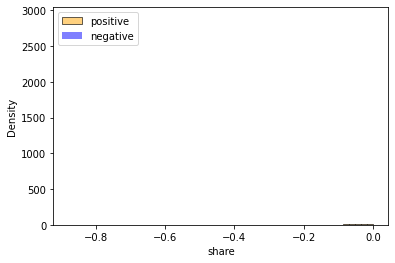

In [7]:
sns.histplot(-df_train.share[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-df_train.share[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

# Q2

In [8]:
cat_col = df_train.select_dtypes(exclude=np.number).columns.to_list()
train_col = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]


In [9]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9739783600107306

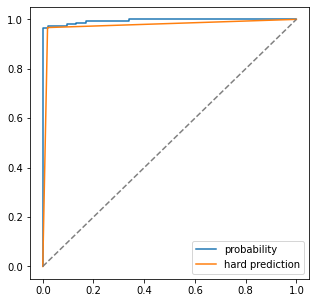

In [10]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

# Q3

In [11]:
'''


Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them


'''

"\n\n\nNow let's compute precision and recall for our model.\n\nEvaluate the model on all thresholds from 0.0 to 1.0 with step 0.01\nFor each threshold, compute precision and recall\nPlot them\n\n\n"

In [12]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores



df_scores = confusion_matrix_dataframe(y_val, y_pred)


df_scores[::10]


,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


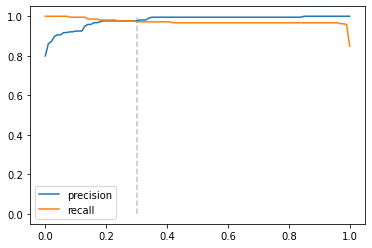

In [13]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)


plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()


In [14]:
df_scores.iloc[np.where(df_scores.p == df_scores.r)][['threshold']]

,threshold
24,0.24
25,0.25
26,0.26
27,0.27
28,0.28
29,0.29


# Q4

In [15]:
'''

Precision and recall are conflicting - when one grows, the other goes down. 
That's why they are often combined into the F1 score - a metrics that takes into account both

'''

"\n\nPrecision and recall are conflicting - when one grows, the other goes down. \nThat's why they are often combined into the F1 score - a metrics that takes into account both\n\n"

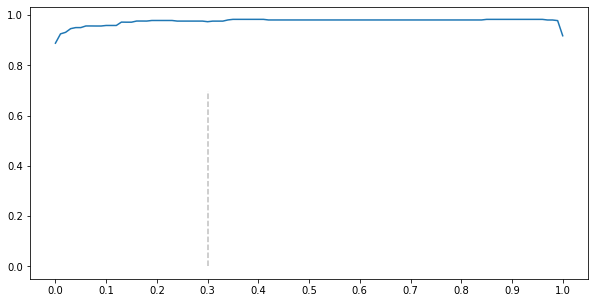

In [16]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()


In [17]:
df_scores.sort_values('f1',ascending=False).head(1)

,threshold,tp,fp,fn,tn,p,r,f1
39,0.39,205,1,6,52,0.995146,0.971564,0.983213


# Q5

In [18]:
'''

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?




'''

"\n\nUse the KFold class from Scikit-Learn to evaluate our model on 5 different folds:\n\nKFold(n_splits=5, shuffle=True, random_state=1)\nIterate over different folds of df_full_train\nSplit the data into train and validation\nTrain the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)\nUse AUC to evaluate the model on validation\nHow large is standard devidation of the AUC scores across different folds?\n\n\n\n\n"

In [19]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[col_names].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000 )
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[col_names].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [20]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


# Q6

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train[col_names]):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.996 +- 0.003
C= 0.1, 0.996 +- 0.003
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003


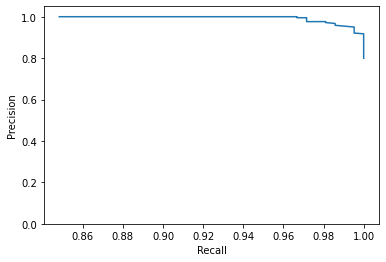

In [22]:
plt.plot(df_scores.r, df_scores.p)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.ylim(0, 1.05)
plt.show()

In [23]:
from sklearn.metrics import auc
df_scores = df_scores.dropna()
auc(df_scores.r, df_scores.p)

0.15045189514248358